<a href="https://colab.research.google.com/github/one-gidung/AI_CAMP/blob/study/05_01_text_classification_%EA%B0%95%EC%9D%98_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 한글폰트 설치
- 아래 실행후 '런터임 다시 시작' 하면 됩니다.
- 메뉴에서 '런타임' >> '런타임 다시 시작'을 클릭하세요.
- 런타임 다시 시작 후 다시 실행할 필요 없습니다.

In [1]:
# 폰트 설치
!apt-get update -qq # 나눔고딕 설치
!apt-get install fonts-nanum* -qq

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 로딩
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
plt.rc('font', family='NanumBarunGothic') 
mpl.font_manager._rebuild()

W: Failed to fetch https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64/InRelease  504  Gateway Timeout [IP: 152.199.20.126 443]
W: Failed to fetch https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64/InRelease  504  Gateway Timeout [IP: 152.199.20.126 443]
W: Some index files failed to download. They have been ignored, or old ones used instead.
Selecting previously unselected package fonts-nanum.
(Reading database ... 146374 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-

# Install

In [1]:
!pip install sentencepiece

     |████████████████████████████████| 1.2MB 16.8MB/s 


# Evn

In [2]:
import os
import random
import shutil
import json
import zipfile
import math
import copy
import collections
import re

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
import sentencepiece as spm
import tensorflow as tf
import tensorflow.keras.backend as K

from tqdm.notebook import tqdm

In [3]:
# random seed initialize
random_seed = 1234
random.seed(random_seed)
np.random.seed(random_seed)
tf.random.set_seed(random_seed)

In [4]:
!nvidia-smi

Fri Jan 29 12:03:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    26W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [8]:
# google drive mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
# data dir
data_dir = '/content/drive/MyDrive/AI 캠프/data'
os.listdir(data_dir)

['ko_32000.vocab', 'ko_32000.model', 'kowiki']

In [11]:
# nsmc dir
nsmc_dir = os.path.join(data_dir, 'nsmc')
if not os.path.exists(nsmc_dir):
    os.makedirs(nsmc_dir)
os.listdir(nsmc_dir)

[]

# Vocabulary & config

In [12]:
# vocab loading
vocab = spm.SentencePieceProcessor()
vocab.load(os.path.join(data_dir, 'ko_32000.model'))

True

In [13]:
n_vocab = len(vocab)  # number of vocabulary
n_seq = 47  # number of sequence
d_model = 256  # dimension of model
n_out = 2  # number of output class

# 모델링

In [14]:
# 입력 문장
sentences = [
    '나는 오늘 기분이 좋아',
    '나는 오늘 우울해'
]

# 출력 정답
labels = [1, 0]  # 긍정(1), 부정(0)

In [15]:
# 각 문장을 띄어쓰기 단위로 분할
words = []
for sentence in sentences:
    words.extend(sentence.split())

# 중복 단어 제거
words = list(dict.fromkeys(words))

# 각 단어별 고유한 번호 부여
word_to_id = {'[PAD]': 0, '[UNK]': 1}
for word in words:
    word_to_id[word] = len(word_to_id)

# 각 숫자별 단어 부여
id_to_word = {_id:word for word, _id in word_to_id.items()}

word_to_id, id_to_word

({'[PAD]': 0, '[UNK]': 1, '기분이': 4, '나는': 2, '오늘': 3, '우울해': 6, '좋아': 5},
 {0: '[PAD]', 1: '[UNK]', 2: '나는', 3: '오늘', 4: '기분이', 5: '좋아', 6: '우울해'})

In [16]:
# 학습용 입력 데이터 생성
train_inputs = []
for sentence in sentences:
    train_inputs.append([word_to_id[word] for word in sentence.split()])

# train label
train_labels = labels

# 문장의 길이를 모두 동일하게 변경 (최대길이 4)
for row in train_inputs:
    row += [0] * (4 - len(row))

# train inputs을 numpy array로 변환
train_inputs = np.array(train_inputs)

# 학습용 정답을 numpy array로 변환
train_labels = np.array(train_labels)

train_inputs, train_labels

(array([[2, 3, 4, 5],
        [2, 3, 6, 0]]), array([1, 0]))

In [21]:
# 입력 단어를 vector로 변환
embedding = tf.keras.layers.Embedding(len(word_to_id), 5)
hidden = embedding(train_inputs)
hidden

<tf.Tensor: shape=(2, 4, 5), dtype=float32, numpy=
array([[[ 0.02343402, -0.01074823,  0.01522658, -0.04609389,
         -0.04044588],
        [-0.02594056, -0.03957871, -0.04964957,  0.02257201,
         -0.0427069 ],
        [ 0.00367712,  0.00880659,  0.04546959,  0.04229597,
         -0.03289993],
        [-0.00211576, -0.01116402,  0.00370605,  0.03210983,
          0.02358914]],

       [[ 0.02343402, -0.01074823,  0.01522658, -0.04609389,
         -0.04044588],
        [-0.02594056, -0.03957871, -0.04964957,  0.02257201,
         -0.0427069 ],
        [-0.02757563, -0.03303362,  0.00482216,  0.01016521,
          0.00992071],
        [ 0.04099175,  0.01676757, -0.03006136, -0.01715951,
         -0.04548226]]], dtype=float32)>

In [22]:
# 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
pool = tf.keras.layers.GlobalMaxPool1D()
hidden_pool = pool(hidden)
hidden_pool

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.02343402, 0.00880659, 0.04546959, 0.04229597, 0.02358914],
       [0.04099175, 0.01676757, 0.01522658, 0.02257201, 0.00992071]],
      dtype=float32)>

In [24]:
# 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
outputs = linear(hidden_pool)
outputs

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[0.4954841 , 0.5045159 ],
       [0.49734843, 0.50265163]], dtype=float32)>

In [26]:
# 예측을 위한 wegiths
weight, bias = linear.get_weights()
weight, bias

(array([[-0.91819006, -0.1704942 ],
        [ 0.28390932, -0.66864836],
        [-0.3321268 ,  0.47714794],
        [ 0.59610987, -0.38089418],
        [-0.22319055,  0.3472923 ]], dtype=float32),
 array([0., 0.], dtype=float32))

In [29]:
def build_model(n_vocab, d_model, n_seq, n_out):
    """
    문장의 감정분류 모델
    :param n_vocab: vocabulary 단어 수
    :param d_model: 단어를 의미하는 벡터의 차원 수
    :param n_seq: 문장길이 (단어 수)
    :param n_out: 예측할 class 개수
    """
    inputs = tf.keras.layers.Input((n_seq,))  # (bs, n_seq)
    ######################################################
    # 입력 단어를 vector로 변환
    embedding = tf.keras.layers.Embedding(n_vocab, d_model)
    hidden = embedding(inputs)      # (bs, n_seq, d_model)

    # RNN, CNN, Dense

    # 각 단어 벡터의 최대값 기준으로 벡터를 더해서 차원을 줄여줌 (문장 vector 생성)
    pool = tf.keras.layers.GlobalMaxPool1D()
    hidden_pool = pool(hidden)      # (bs, d_model)
    
    # 문장 vector를 이용해서 긍정(1), 부정(0) 확률값 예측
    linear = tf.keras.layers.Dense(2, activation=tf.nn.softmax)
    outputs = linear(hidden_pool)
    ######################################################
    # 학습할 모델 선언
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    return model

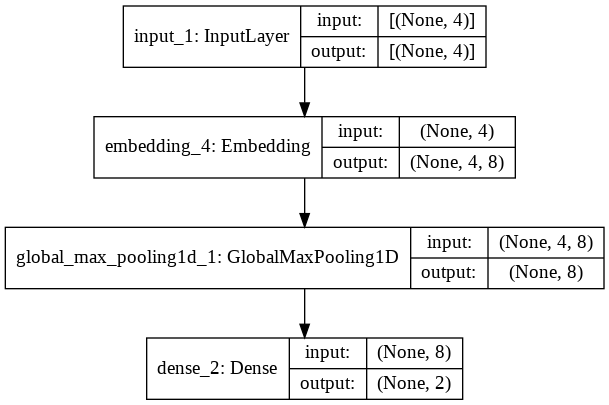

In [30]:
# 모델 생성
model = build_model(len(word_to_id), 8, 4, 2)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [31]:
model.predict(train_inputs)

array([[0.5139493 , 0.4860507 ],
       [0.5017904 , 0.49820957]], dtype=float32)

# 다운로드
- https://github.com/e9t/nsmc

In [ ]:
!wget https://github.com/e9t/nsmc/raw/master/ratings_train.txt
!wget https://github.com/e9t/nsmc/raw/master/ratings_test.txt

In [ ]:
shutil.move('ratings_train.txt', os.path.join(nsmc_dir, 'ratings_train.txt'))
shutil.move('ratings_test.txt', os.path.join(nsmc_dir, 'ratings_test.txt'))
os.listdir(nsmc_dir)

# 데이터 분석

In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

In [ ]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

## Char

In [ ]:
# char 길이 데이터
char_len = df_train["document"].astype("str").apply(len)
char_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(char_len, bins=200, range=[0, 200], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of char')
# 그래프 x 축 라벨
plt.xlabel('Number of char')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"char 길이 최대:    {np.max(char_len):4d}")
print(f"char 길이 최소:    {np.min(char_len):4d}")
print(f"char 길이 평균:    {np.mean(char_len):7.2f}")
print(f"char 길이 표준편차: {np.std(char_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(char_len, 25)
percentile50 = np.percentile(char_len, 50)
percentile75 = np.percentile(char_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"char 25/100분위:  {percentile25:7.2f}")
print(f"char 50/100분위:  {percentile50:7.2f}")
print(f"char 75/100분위:  {percentile75:7.2f}")
print(f"char IQR:        {percentileIQR:7.2f}")
print(f"char MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(char_len, labels=['char counts'], showmeans=True)
plt.show()

## Word

In [ ]:
# word 길이 데이터
word_len = df_train['document'].astype(str).apply(lambda x:len(x.split(' ')))
word_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(word_len, bins=50, range=[0, 50], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of word')
# 그래프 x 축 라벨
plt.xlabel('Number of word')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"word 길이 최대:    {np.max(word_len):4d}")
print(f"word 길이 최소:    {np.min(word_len):4d}")
print(f"word 길이 평균:    {np.mean(word_len):7.2f}")
print(f"word 길이 표준편차: {np.std(word_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(word_len, 25)
percentile50 = np.percentile(word_len, 50)
percentile75 = np.percentile(word_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"word 25/100분위:  {percentile25:7.2f}")
print(f"word 50/100분위:  {percentile50:7.2f}")
print(f"word 75/100분위:  {percentile75:7.2f}")
print(f"word IQR:        {percentileIQR:7.2f}")
print(f"word MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(word_len, labels=['word counts'], showmeans=True)
plt.show()

## SentencePiece

In [ ]:
# word 길이 데이터
spm_len = df_train['document'].astype(str).apply(lambda x:len(vocab.encode_as_pieces(x)))
spm_len.head(10)

In [ ]:
# 그래프에 대한 이미지 사이즈 선언
# figsize: (가로, 세로) 형태의 튜플로 입력
plt.figure(figsize=(8, 4))
# histogram 선언
# bins: 히스토그램 값들에 대한 버켓 범위, 
# range: x축 값의 범위
# facecolor: 그래프 색상
# label: 그래프에 대한 라벨
plt.hist(spm_len, bins=110, range=[0, 110], facecolor='r', label='train')
# 그래프 제목
plt.title('Lengh of spm')
# 그래프 x 축 라벨
plt.xlabel('Number of spm')
# 그래프 y 축 라벨
plt.ylabel('Count of review')
plt.show()

In [ ]:
# 데이터 길이
print(f"spm 길이 최대:    {np.max(spm_len):4d}")
print(f"spm 길이 최소:    {np.min(spm_len):4d}")
print(f"spm 길이 평균:    {np.mean(spm_len):7.2f}")
print(f"spm 길이 표준편차: {np.std(spm_len):7.2f}")
# https://ko.wikipedia.org/wiki/%EB%B0%B1%EB%B6%84%EC%9C%84%EC%88%98
# 백분위수(Percentile)는 크기가 있는 값들로 이뤄진 자료를 순서대로 나열했을 때 백분율로 나타낸 특정 위치의 값을 이르는 용어이다.
# 일반적으로 크기가 작은 것부터 나열하여 가장 작은 것을 0, 가장 큰 것을 100으로 한다.
# 100개의 값을 가진 어떤 자료의 20 백분위수는 그 자료의 값들 중 20번째로 작은 값을 뜻한다. 50 백분위수는 중앙값과 같다.
percentile25 = np.percentile(spm_len, 25)
percentile50 = np.percentile(spm_len, 50)
percentile75 = np.percentile(spm_len, 75)
percentileIQR = percentile75 - percentile25
percentileMAX = percentile75 + percentileIQR * 1.5
print(f"spm 25/100분위:  {percentile25:7.2f}")
print(f"spm 50/100분위:  {percentile50:7.2f}")
print(f"spm 75/100분위:  {percentile75:7.2f}")
print(f"spm IQR:        {percentileIQR:7.2f}")
print(f"spm MAX/100분위: {percentileMAX:7.2f}")

In [ ]:
plt.figure(figsize=(4, 6))
# 박스플롯 생성
# 첫번째 파라메터: 여러 분포에 대한 데이터 리스트를
# labels: 입력한 데이터에 대한 라벨
# showmeans: 평균값을 표현
# 참고: https://leebaro.tistory.com/entry/%EB%B0%95%EC%8A%A4-%ED%94%8C%EB%A1%AFbox-plot-%EC%84%A4%EB%AA%85
plt.boxplot(spm_len, labels=['spm counts'], showmeans=True)
plt.show()

## Label

In [ ]:
df_train['label'].value_counts()

In [ ]:
# label count
print(f"부정 리뷰 개수: {df_train['label'].value_counts()[0]}")
print(f"긍정 리뷰 개수: {df_train['label'].value_counts()[1]}")

In [ ]:
# label counter plot
fig, axe = plt.subplots(ncols=1)
fig.set_size_inches(6, 5)
# https://seaborn.pydata.org/
subplt = sns.countplot(df_train['label'])

## Word Cloud

In [ ]:
# train review documents
train_review = [review for review in df_train['document'] if type(review) is str]
train_review[:10]

In [ ]:
' '.join(train_review[:10])

In [ ]:
# WordCloud
# window: C:/Windows/Fonts/malgun.ttf, mac: /Library/Fonts/AppleGothic.ttf, colab: /usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf
wordcloud = WordCloud(width=800, height=800, font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf').generate(' '.join(train_review))
plt.figure(figsize=(10, 10))
# https://datascienceschool.net/view-notebook/6e71dbff254542d9b0a054a7c98b34ec/
# image 출력, interpolation 이미지 시각화 옵션
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

# Sample Data Project

## Data


In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

In [ ]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

In [ ]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

In [ ]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

In [ ]:
# 랜덤하게 10개만 확인
df_train = df_train.sample(10)
df_train

In [ ]:
# 랜덤하게 10개만 확인
df_test = df_test.sample(10)
df_test

In [ ]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        ######################################
        ######################################
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels

In [ ]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# 모델 학습
history = model.fit(train_inputs, train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## 학습 2

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화

In [ ]:
# 예측

array([[0.5108406 , 0.48915946],
       [0.5154145 , 0.48458552],
       [0.5173925 , 0.48260748],
       [0.5119674 , 0.48803252],
       [0.51763374, 0.48236626],
       [0.5153199 , 0.48468015],
       [0.51243275, 0.48756722],
       [0.5175908 , 0.4824092 ],
       [0.512544  , 0.48745605],
       [0.5115084 , 0.48849162]], dtype=float32)

In [ ]:
# 확률 최대 값을 예측으로 사용

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [ ]:
# confusion matrix
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

array([[6, 0],
       [4, 0]])

In [ ]:
# accuracy, precision, recall, f1
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

In [ ]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
    pass

In [ ]:
string = '영화 너무 심심해'
do_predict(model, n_seq, string)

In [ ]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")

# All Data Project

## Data


In [ ]:
# train data load
df_train = pd.read_csv(os.path.join(nsmc_dir, 'ratings_train.txt'), delimiter='\t')
df_train

In [ ]:
# train null 데이터 제거
df_train = df_train.dropna()
df_train

In [ ]:
# train data load
df_test = pd.read_csv(os.path.join(nsmc_dir, 'ratings_test.txt'), delimiter='\t')
df_test

In [ ]:
# train null 데이터 제거
df_test = df_test.dropna()
df_test

In [ ]:
def load_data(df, n_seq):
    """
    NSMC 학습 데이터 생성
    :param df: data frame
    :param n_seq: number of sequence
    :return inputs: input data
    :return labels: label data
    """
    inputs = np.zeros((len(df), n_seq)).astype(np.int32)
    labels = np.zeros((len(df),))
    index = 0
    for i, row in tqdm(df.iterrows(), total=len(df)):
        # tokens 저장
        # print()
        label = row['label']
        document = row['document']
        # print(label, document)
        tokens = vocab.encode_as_pieces(document)
        # print(len(tokens), ':', tokens)
        token_ids = vocab.encode_as_ids(document)
        # print(len(token_ids), ':', token_ids)
        token_ids = token_ids[:n_seq]
        # print(len(token_ids), ':', token_ids)
        token_ids += [0] * (n_seq - len(token_ids))
        # print(len(token_ids), ':', token_ids)

        labels[index] = label
        inputs[index] = token_ids
        index += 1
    return inputs, labels

In [ ]:
# train data 생성
train_inputs, train_labels = load_data(df_train, n_seq)
train_inputs, train_labels

In [ ]:
# test data 생성
test_inputs, test_labels = load_data(df_test, n_seq)
test_inputs, test_labels

## 학습

In [ ]:
# 모델 생성
model = build_model(len(vocab), d_model, n_seq, n_out)
# 모델 내용 그래프 출력
tf.keras.utils.plot_model(model, 'model.png', show_shapes=True)

In [ ]:
# 모델 loss, optimizer, metric 정의
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5)
# save weights callback
save_weights = tf.keras.callbacks.ModelCheckpoint(os.path.join(nsmc_dir, 'stub.hdf5'),
                                                  monitor='val_accuracy',
                                                  verbose=1,
                                                  save_best_only=True,
                                                  mode="max",
                                                  save_freq="epoch",
                                                  save_weights_only=True)
# csv logger
csv_logger = tf.keras.callbacks.CSVLogger(os.path.join(nsmc_dir, 'stub.csv'))

In [ ]:
# 모델 학습
history = model.fit(train_inputs,
                    train_labels,
                    validation_data=(test_inputs, test_labels),
                    epochs=100,
                    batch_size=256,
                    callbacks=[early_stopping, save_weights, csv_logger])

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b-', label='loss')
plt.plot(history.history['val_loss'], 'r--', label='val_loss')
plt.xlabel('Epoch')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'g-', label='acc')
plt.plot(history.history['val_accuracy'], 'k--', label='val_acc')
plt.xlabel('Epoch')
plt.legend()

plt.show()

## Inference

In [ ]:
# 모델 생성
model = build_model(n_vocab, d_model, n_seq, n_out)
# train weight로 초기화
model.load_weights(os.path.join(nsmc_dir, 'stub.hdf5'))

In [ ]:
# 예측
logits = model.predict(test_inputs)
logits

In [ ]:
# 확률 최대 값을 예측으로 사용
test_preds = np.argmax(logits, axis=-1)
test_preds

In [ ]:
confusion_matrix = np.zeros((n_out, n_out)).astype(np.int)
for y_true, y_pred in zip(test_labels, test_preds):
    confusion_matrix[int(y_true), int(y_pred)] += 1
confusion_matrix

In [ ]:
tp = confusion_matrix[1, 1]
tn = confusion_matrix[0, 0]
fp = confusion_matrix[0, 1]
fn = confusion_matrix[1, 0]

accuracy = (tp + tn) / max((tp + tn + fp + fn), 1)
print(f'accuracy: {accuracy}')
precision = (tp) / max((tp + fp), 1)
print(f'precision: {precision}')
recall = (tp) / max((tp + fn), 1)
print(f'recall: {recall}')
f1 = 2 * (precision * recall) / max((precision + recall), 1)
print(f'f1: {f1}')

In [ ]:
def do_predict(model, n_seq, string):
    """
    입력에 대한 답변 생성하는 함수
    :param model: model
    :param n_seq: 입력 개수
    :param string: 입력 문자열
    """
    # token 생성: <string tokens>, [PAD] tokens
    token = vocab.encode_as_ids(string)[:n_seq]
    token += [0] * (n_seq - len(token))
    token = token[:n_seq]

    y_pred = model.predict(np.array([token]))
    y_pred_class = K.argmax(y_pred, axis=-1)

    return "긍정" if y_pred_class[0] == 1 else "부정"

In [ ]:
while True:
    print("input > ", end="")
    string = str(input())
    if len(string) == 0:
        break
    print(f"output > {do_predict(model, n_seq, string)}")